# Climate Analysis
Now that the data is cleaned and packaged in an SQLite database, we will perform some basic climate analyses to explore and understand the data.

This process will allow us to prototype some of the functions and queries that the final climate app will use to query and serve the data to the user.

## Bringing the Data Into Python
We will use SQLAlchemy to bring the data back out of the database, and reflect the database schema in terms of Python classes. This will allow us to easily deal with query results as objects.

SQLAlchemy's `automap_base()` will allow us to do this very easily.

To more easily aggregate and visualize the data, we will then transform the query results into PANDAS dataframes.

### Dependencies

In [1]:
import pandas as pd
import datetime as dt

import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

### Connecting to the Database
Here we supply the database url to create an engine object, and use the `.connect()` method to initiate the connection.

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite')
conn = engine.connect()

### Reflecting the Database Schema
This step reflects the database schema in terms of Python classes, so we can work with query results in terms of Python class objects.

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
# check reflected table names
Base.classes.keys()

['hawaii_measurements', 'hawaii_stations']

In [5]:
# create references to reflected tables to use during query
Station = Base.classes.hawaii_stations
Measurement = Base.classes.hawaii_measurements

### Opening a Session and Querying Database
Here we begin a session to query the database, using our configured `engine`.

Using `session`'s `.query()` method will allow us to query the database in a Pythonic way, with SQLAlchemy emitting the required SQL, and returning the data as Python objects.

Check [SQLAlchemy's ORM Tutorial: Querying](https://docs.sqlalchemy.org/en/latest/orm/tutorial.html#querying) for more information on how to use `.query()`.

In [6]:
session = Session(engine)

In [7]:
# query for first row in hawaii_measurements table to look at data structure
first_row = session.query(Measurement).first()

In [8]:
# look at returned object attributes using __dict__
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10ff920f0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

## Precipitation
To understand the rainfall patterns in Hawaii better, let's design a query to pull the last 12 months of precipitation data from the database, then make a bar graph to visualize it.

Because the data was collected more than a year ago, we will first find the last date in the database, then go 12 months back from that.

### Finding Last Date in Database
Here we use sqlalchemy's `func.max()` to find the latest date in the database

In [9]:
# import func to use func.max() on date column
from sqlalchemy import func
# .scalar() extracts first element of first result
last_db_date = session.query(func.max(Measurement.date)).scalar()
print("The most recent date in the database is: ", last_db_date)

The most recent date in the database is:  2017-08-23


In [10]:
# convert query result to datetime object to perform time math
last_datetime = dt.datetime.strptime(last_db_date, '%Y-%m-%d')
year_ago_datetime = last_datetime - dt.timedelta(days=365)
print("The date one year before the most recent date in the database is: ", year_ago_datetime.strftime('%Y-%m-%d'))

The date one year before the most recent date in the database is:  2016-08-23


### Querying for 12 Months of Precipitation Data
Here we pass in our start date, `year_ago_datetime`, into the filter method to get back only 12 months of data

In [11]:
# extracting relevant data from date, precipitation columns from hawaii_measurements table
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_datetime).all()
#stat = pd.DataFrame(session.query(Station).all())

### Loading Query Results into a PANDAS DataFrame
The results array can be easily transformed to a dataframe after query.

Because there are multiple precipitation measurements for any given date (remember, 9 stations reporting), the data will need to be grouped and aggregated before plotting. I chose to take the average of precipitation measurements for each day, by grouping by date, then applying `.mean()` to return the desired dataframe.

In [12]:
# Transform results to dataframe
last_yr_prcp = pd.DataFrame(results)
last_yr_prcp.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [13]:
last_yr_prcp.date = pd.to_datetime(last_yr_prcp.date, format='%Y-%m-%d', errors='ignore')
last_yr_prcp.date.dtype

dtype('<M8[ns]')

In [14]:
# groupby date and aggregate by mean
agg_prcp = last_yr_prcp.groupby('date').mean()
agg_prcp.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [15]:
# check that we have one year of dates
print("Number of days represented in dataframe: ", len(agg_prcp.index))

Number of days represented in dataframe:  365


### Plot Precipitation
An interesting note. I first tried to plot the dataframe as is (using the index as X), but PANDAS made the plot with a too-dense set of x-tick labels. PANDAS is supposed to lower the resolution, only printing some x-tick labels, but I could not figure out why it wasn't doing this.

I decided instead to construct a date index by hand using `pd.date_range()`. Supplying this as the x-axis caused PANDAS to format the plot correctly, with x-tick labels of low density. Still trying to figure out what happened. It seems that it worked because PANDAS didn't like the datatype `dtype('<M8[ns]')` of the index column, but because the custom DateRange Index was of a different datatype, it worked. Funny.

<IPython.core.display.Javascript object>


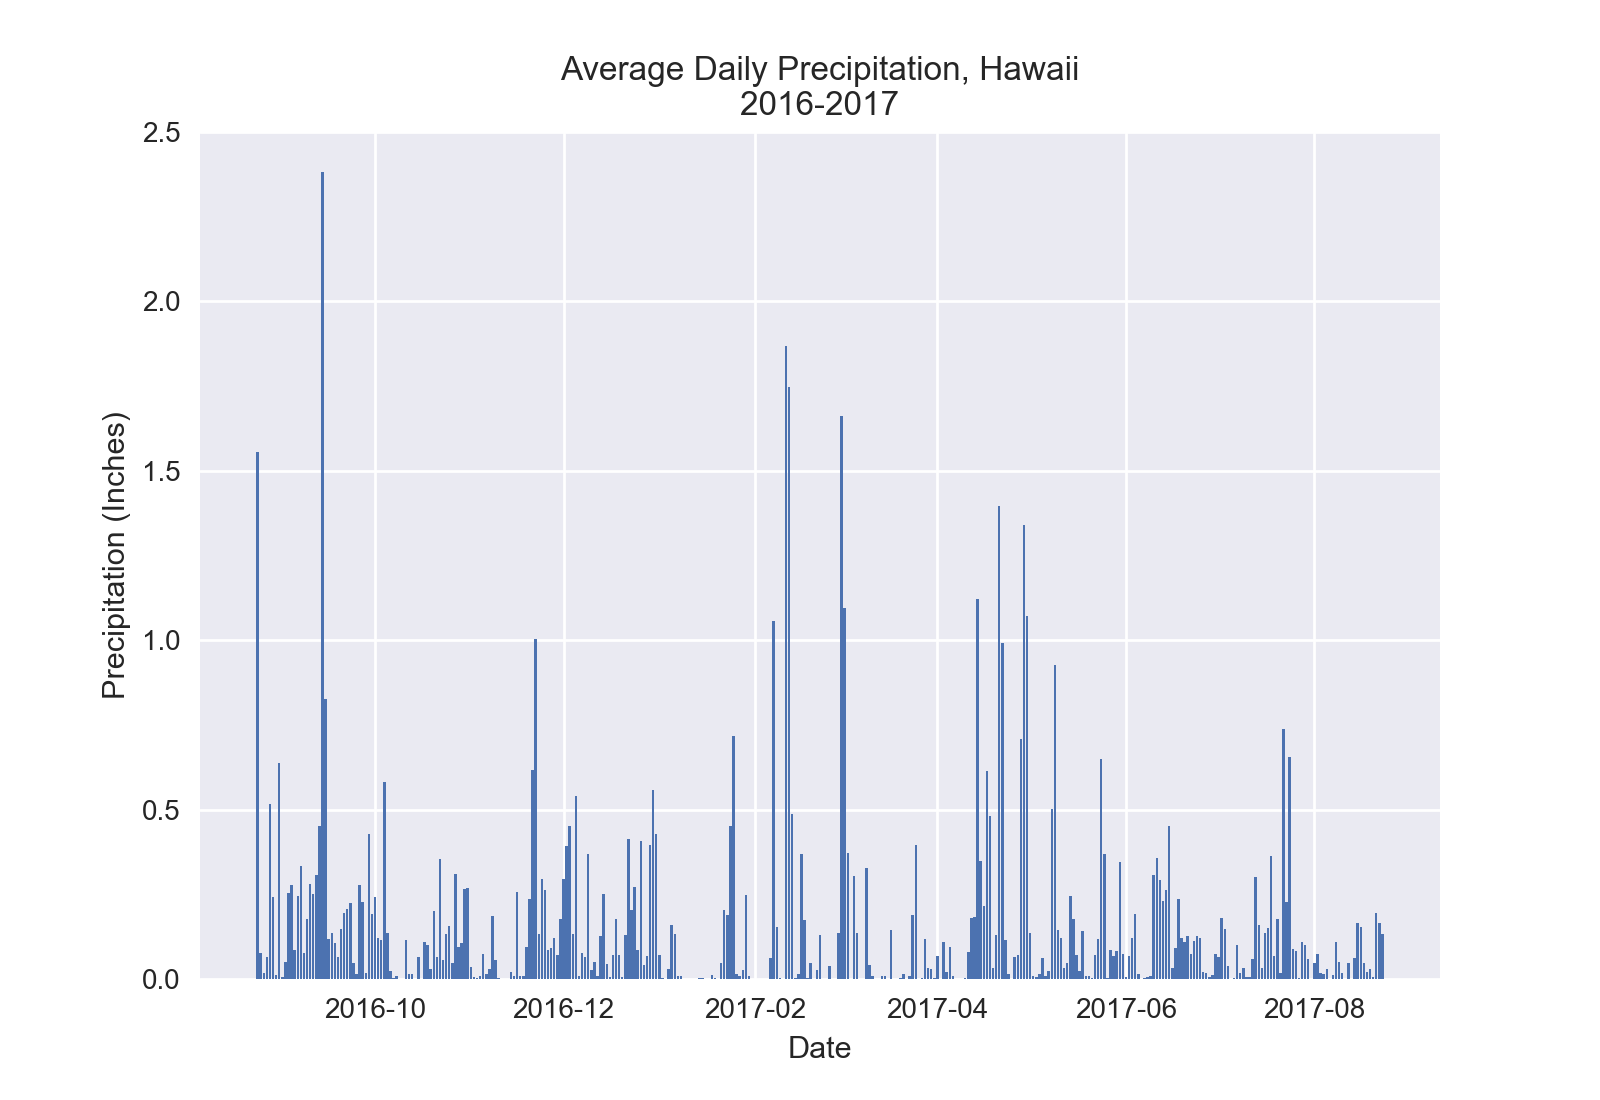

In [16]:
# construct date range identical to index
dates = pd.date_range('2016-08-24', '2017-08-23', freq='D')
# plot bar graph using date range
plt.bar(dates, agg_prcp.prcp)
plt.title('Average Daily Precipitation, Hawaii\n2016-2017')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.show()

As we can see here, average rainfall across the island of Hawaii highly variable. Drier periods seem to occur in November, mid-January, late March, and July. Wetter periods seem to occur in September, February, and May.

## Station Analysis

In order to further explore the data, let's find out more about the stations, specifically:
- How many stations are there?
- Which station is the most active (has the largest number of observations)?

In order to visualize the temperature distribution, let's also make a histogram of temperatures reported by the most active station.

### Explore Station Table Fields with ```.__dict__``` Method

In [17]:
first_row = session.query(Station).first()

In [18]:
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x119676ac8>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

### Count Number of Stations

In [19]:
# use .count() to return number of rows returned by query
number_of_stations = session.query(Station).count()
print("There are", number_of_stations, "stations in total.")

There are 9 stations in total.


### Find Most Active Station

In [20]:
# import func, which allows for the use of aggregating functions in query (like sql's SELECT SUM(column))
# import desc, which allows for descending order by
from sqlalchemy import func, desc

# returns a list of tuples, with first element of each tuple a station id, the second, number of observations
most_active_stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(desc(func.count(Measurement.id))).all()

# extract station id and number of observations from returned tuple list
most_active_station_id = most_active_stations[0][0]
most_active_station_nobs = most_active_stations[0][1]

# convert station id to station name using query of Station table
most_active_station_name = session.query(Station.name).filter(Station.station == most_active_station_id).first()[0]

print("The most active station is",
      most_active_station_name,
      ", id #:",
      most_active_station_id,
      "with", most_active_station_nobs,
      "observations.")

The most active station is WAIHEE 837.5, HI US , id #: USC00519281 with 2772 observations.


### Query Database for Station Measurements

Before we generate the histogram, we will need to query the database for measurements from the most active station, Waihe'e.

#### Measurement Table Record Example
```python
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1290f94e0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}
```

In [21]:
# filter query by station id
just_waihee = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id).all()

In [22]:
# query returns list of 2-element tuples, with the tobs measurement as the 0th element
# use list comprehension to extract first element from each tuple and drop into a new list
temp_list = [x[0] for x in just_waihee]

### Generate Histogram

<IPython.core.display.Javascript object>


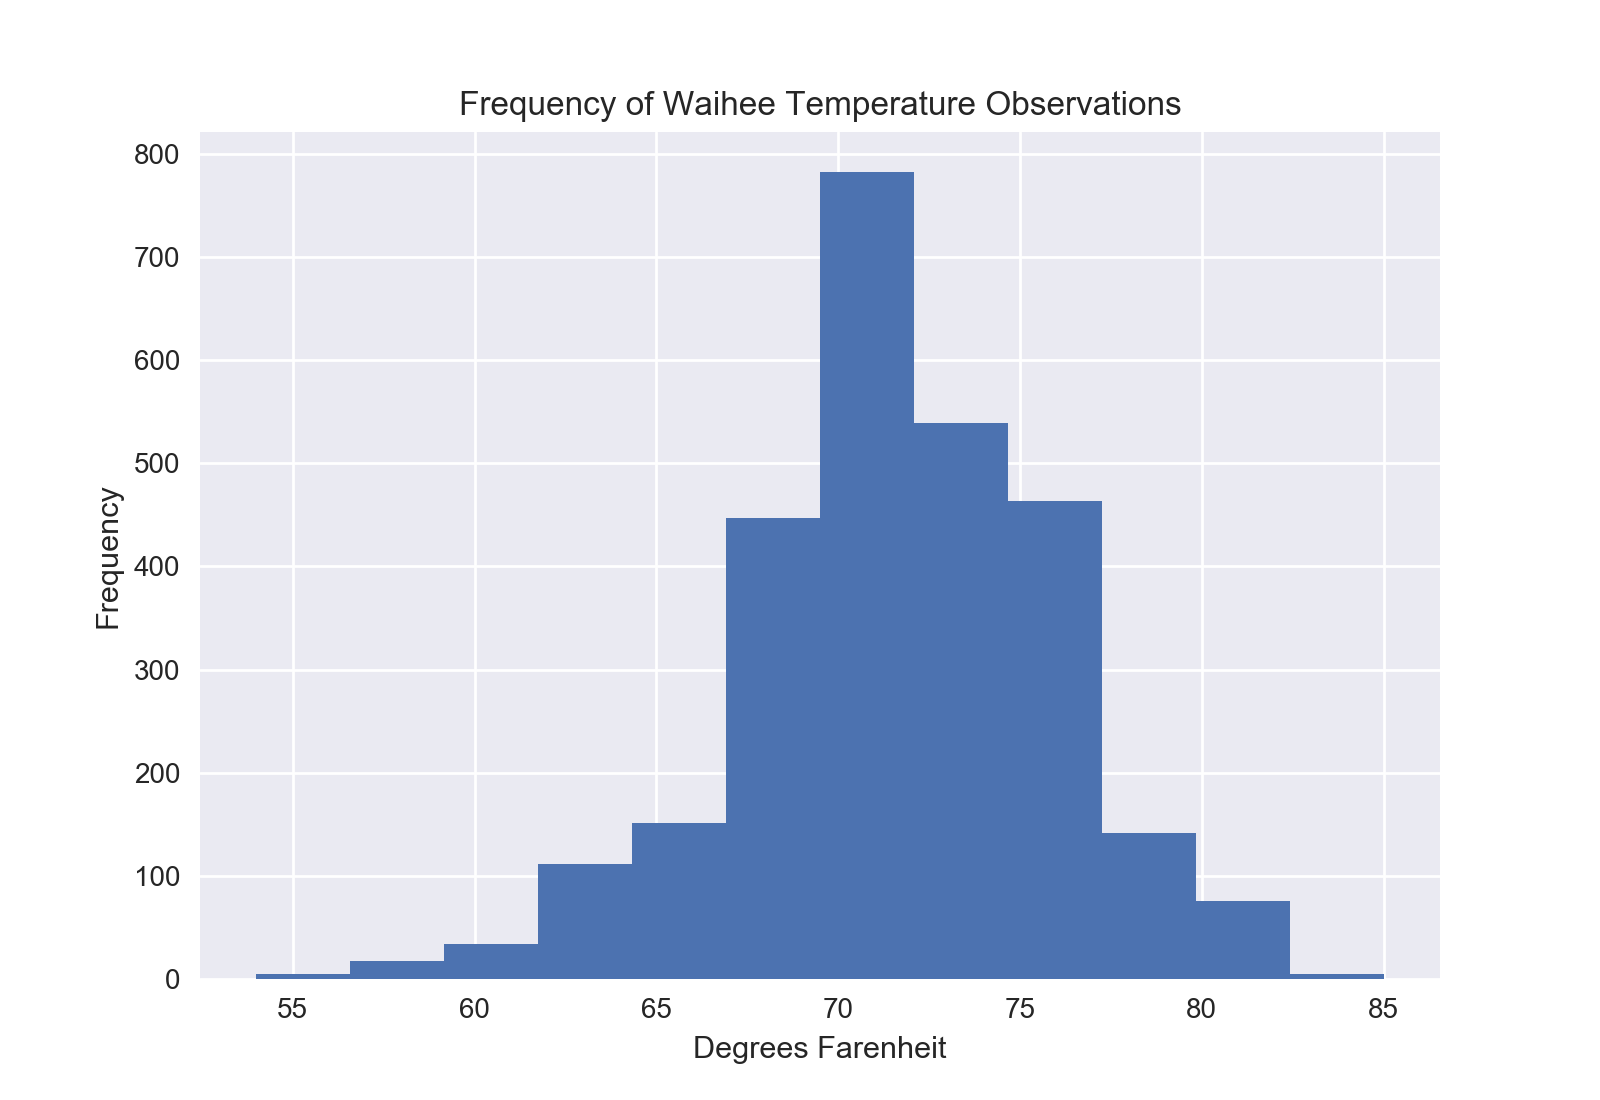

In [23]:
# convert list to series for easy plotting
pd.Series(temp_list).hist(bins=12)
plt.xlabel('Degrees Farenheit')
plt.ylabel('Frequency')
plt.title('Frequency of Waihee Temperature Observations')
plt.show()

The visualization shows that the most frequently observed temperature range in Waihe'e is between 70 and 73 degrees. The majority of temperatures reported are between 67 and 77 degrees.

### Temperature Analysis

When finished, we want our app to be able to accept start and end dates for a trip, and return minimum, maximum, and average temperatures for that range of dates.

#### Strategy

In order to do this, we will write a function that accepts these dates, constructs a database query, and returns the desired results. If we wanted to query the data for dates within a certain range, we could do this:

In [24]:
def calculate_temperatures(start_date, end_date):
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    print(results)
    
calculate_temperatures('2016-01-01', '2016-01-05')

[(62, 76, 69.32142857142857)]


But, trips happen in the future, not the past!

In order to make generalizations about the weather, we need to remove the year from the start and end dates supplied by the user, and query the data for each day during the user's trip, regardless of the year.

Because it would be difficult to query for date ranges without the year (as in a ```.filter_by(Measurement.date < somedate_x).filter(Measurement.date > somedate_y)``` as in the query above, we will have to take a different approach.

We will instead parse the dates the user gives into datetime objects, calculate the number of days between the two dates, and construct a list of days that the trip is for. We will then iterate through this list, constructing queries that filter for only the month and the day of that particular date.

Each iteration will output an average temperature for all stations on one calendar day of the year, over all years.

In this way, we will able to aggregate the results of each "day" query into an average minimum, maximum, and average temperature for all days in the supplied range, over all years.

In [25]:
# import datetime and timedelta to do time math
from datetime import datetime, timedelta
# import mean to do the final averaging of stored query results
from statistics import mean

def calc_temps(start_date, end_date):
    # parse dates to do time delta math
    parsed_start = datetime.strptime(start_date, '%Y-%m-%d')
    parsed_end = datetime.strptime(end_date, '%Y-%m-%d')
    
    # find time delta in days
    delta = parsed_end - parsed_start
    trip_days = delta.days
    
    # create list to hold each trip day
    datetimes_of_trip = []
    
    # create queries for each day in trip
    date = parsed_start
    for day in range(0, trip_days + 1):
        datetimes_of_trip.append(date)
        date = date + timedelta(days=1)
    
    # convert datetimes of each day in trip to %m-%d format for value matching irrespective of year
    query_ready_dates = [datetime.strftime(x, '%m-%d') for x in datetimes_of_trip]
    
    # create lists to hold min, max, and avg for each daily query result
    mins = []
    maxes = []
    avges = []
    
    # iterate through dates to make individual day queries
    for date in query_ready_dates:
        results = session.query(func.min(Measurement.tobs),
                                func.max(Measurement.tobs),
                                func.avg(Measurement.tobs)).\
        filter(Measurement.date.like('%%%%-' + date)).all()
        
        # extract results out of one-element list of 3-element tuple
        tmin = results[0][0]
        tmax = results[0][1]
        tavg = results[0][2]
        
        # append each result to appropriate list
        mins.append(tmin)
        maxes.append(tmax)
        avges.append(tavg)
    
    # average results from each day
    final_min = mean(mins)
    final_max = mean(maxes)
    final_avg = mean(avges)
    
    # return averages for duration of trip
    return final_min, final_max, final_avg

In [26]:
# test function
mintemp, maxtemp, avgtemp = calc_temps('2016-01-01', '2016-01-05')
print(mintemp, maxtemp, avgtemp)

59.6 76.6 69.02757204700062


### Plot Average Temperature with Error Bars

<IPython.core.display.Javascript object>


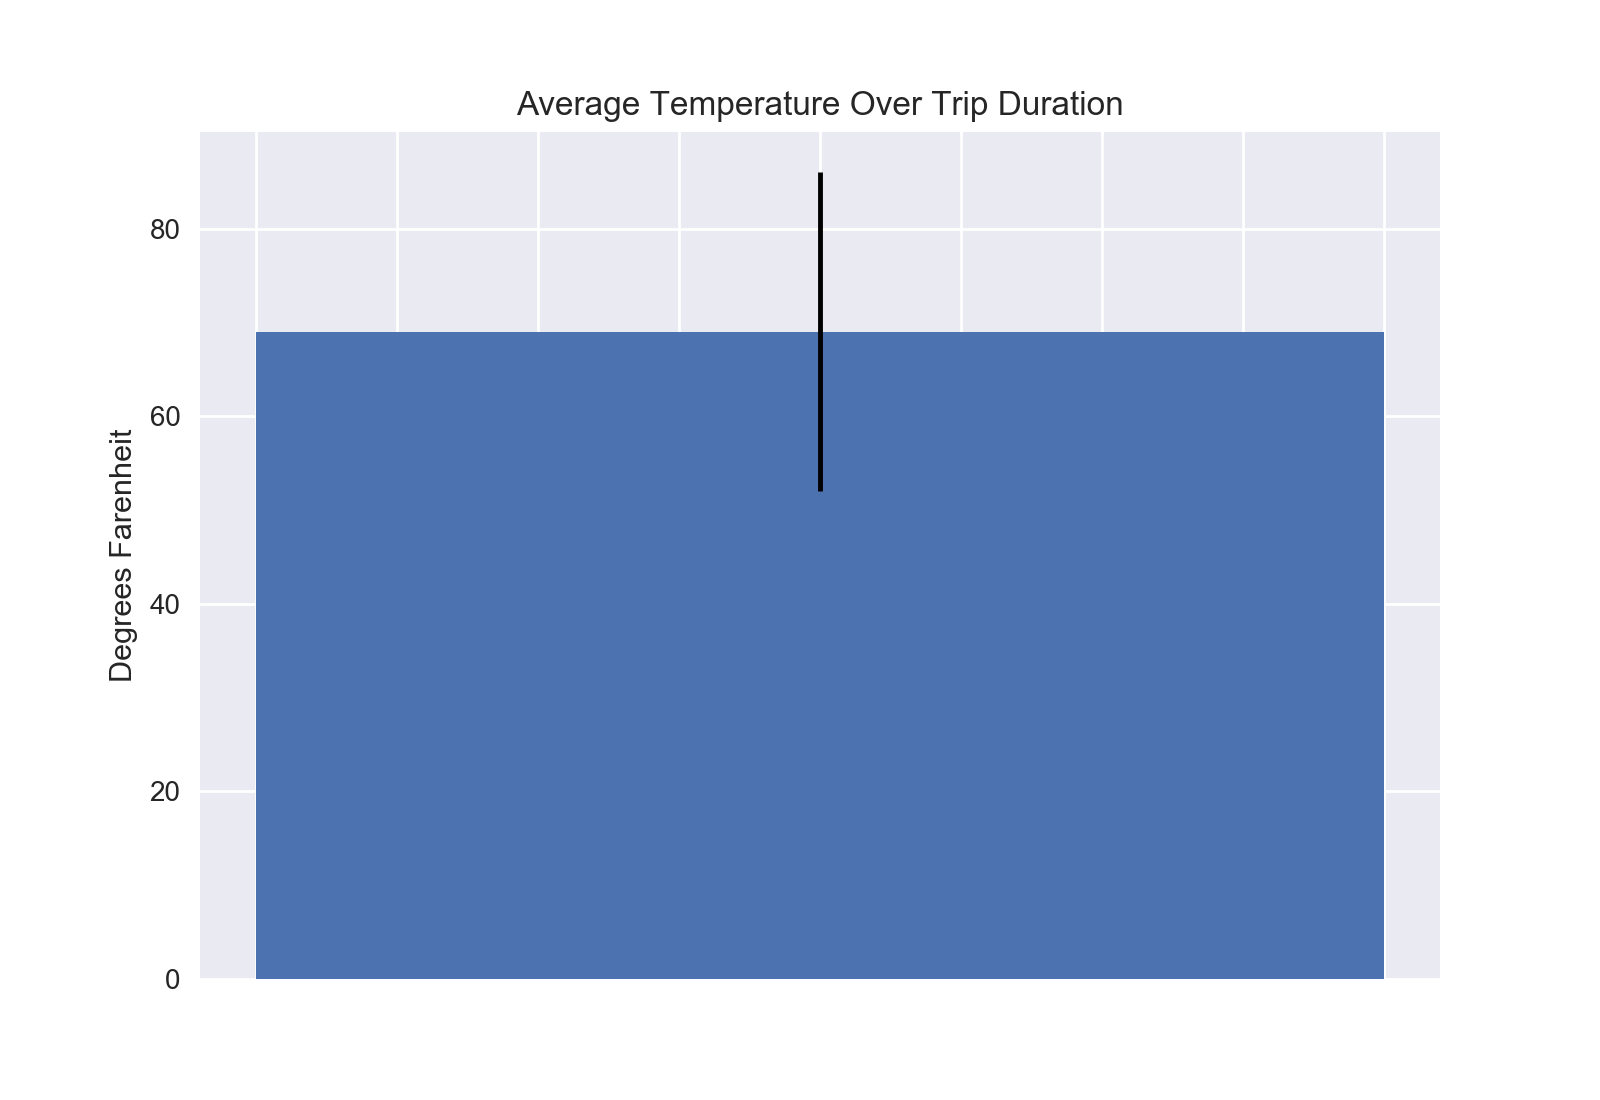

In [27]:
# single column bar plot with error bar
plt.bar(0, avgtemp, yerr=(maxtemp - mintemp))
plt.ylabel('Degrees Farenheit')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.title('Average Temperature Over Trip Duration')
plt.show()

## Rainfall per Station

Next, we will visualize the rainfall per station, given an input date range.